# Trabajo de Fin de Grado
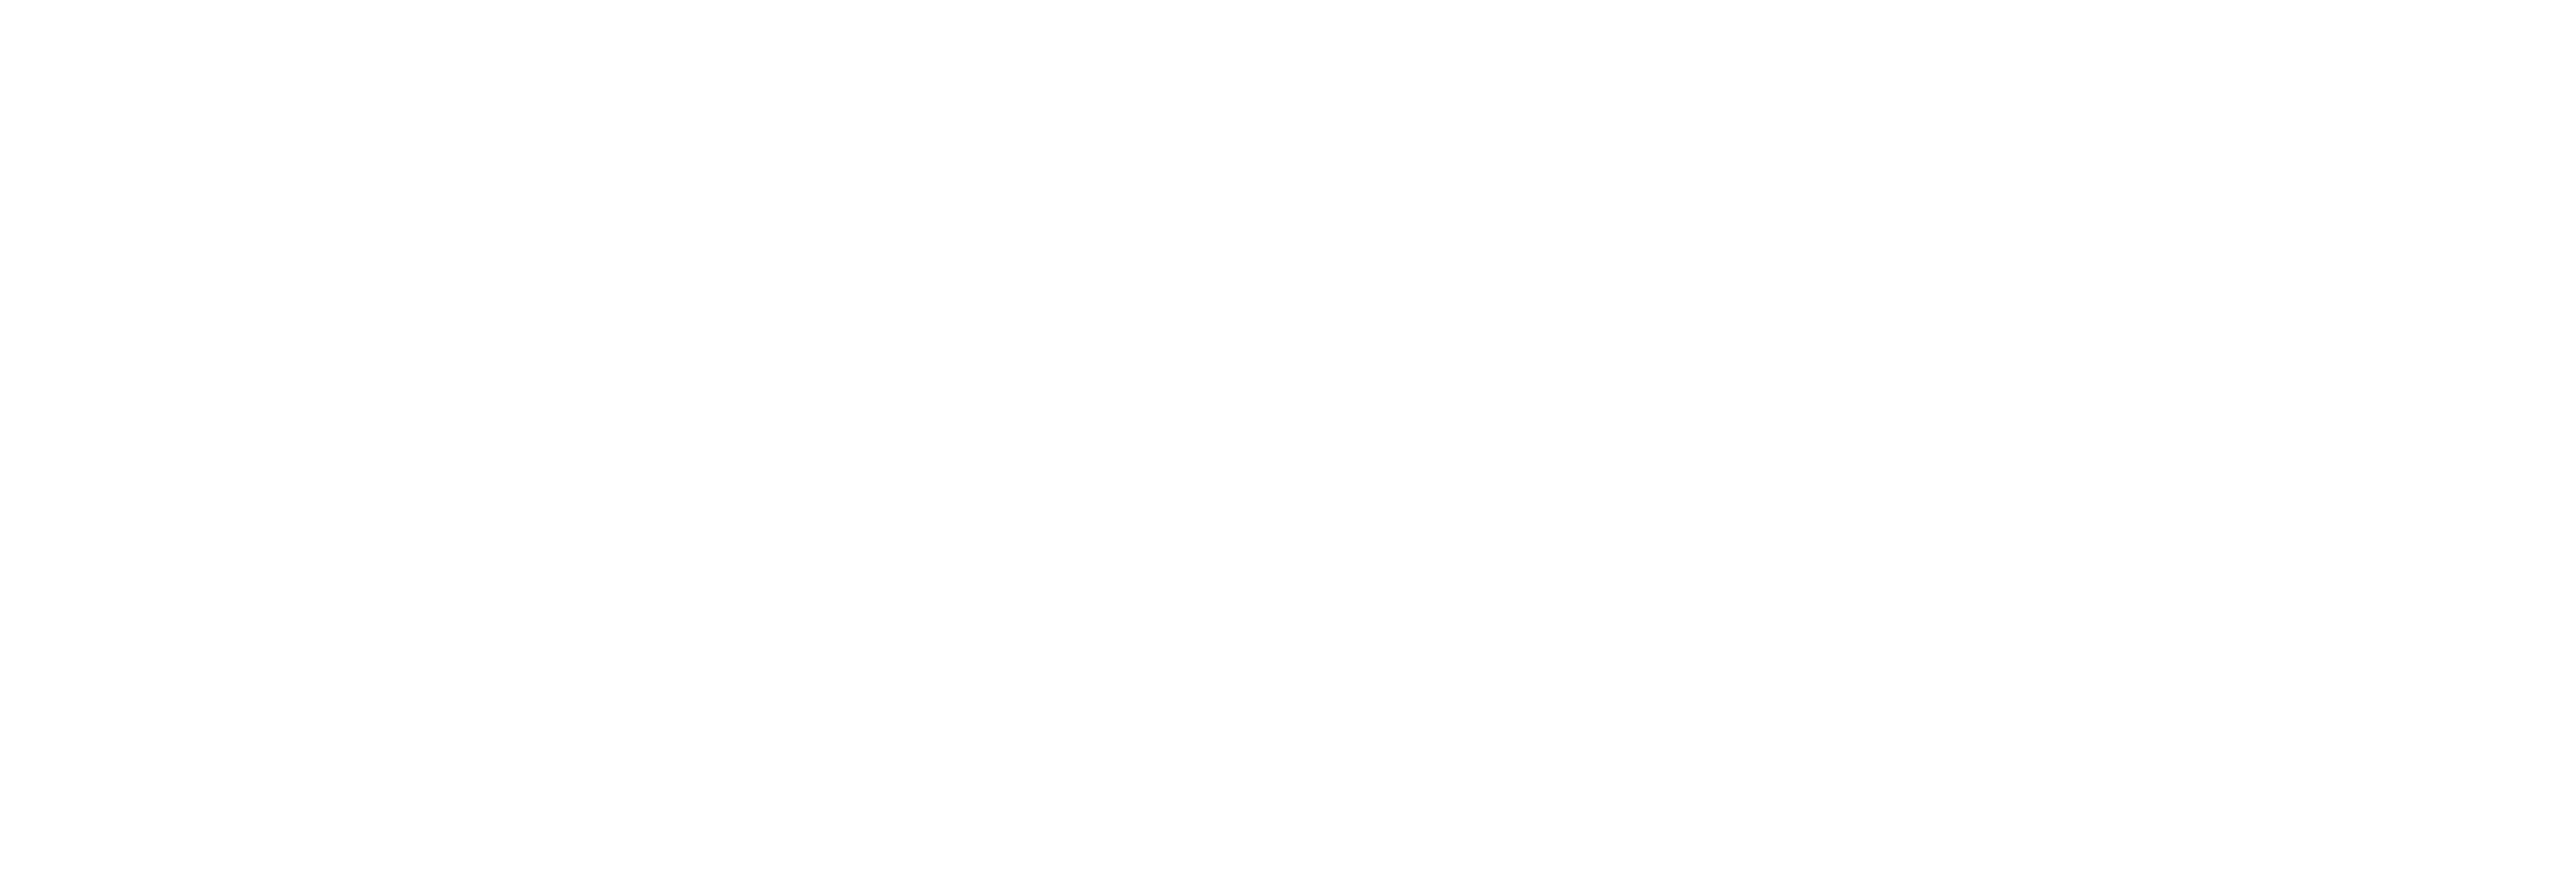

## Grado en Ingeniería Informática
### Clasificación no supervisada de imágenes con transformers multimodales
##### _Pablo García García_

### Configuraciones iniciales

Para comenzar se importarán las librerías necesarias. 

In [1]:
import PIL.Image, os, json, base64, requests, dotenv, time
import numpy as np
import pandas as pd
import sklearn.cluster
import sklearn.decomposition
import matplotlib
import matplotlib.pyplot as plt
import yellowbrick.cluster

A continuación se definen una serie de constantes. 

In [2]:
dotenv.load_dotenv()

RUTA_DATASETS = "../Datasets/"
RUTA_IMG = "../Memoria/img/"
DATASET_ORIGINAL = "tfg_dataset_junto/"
DATASET_PREPROCESADO = "tfg_dataset_transf/"
DIM = 512
GENERAR_EMBEDDINGS = False

API_URL = dotenv.dotenv_values()["API_URL"]
API_KEY = dotenv.dotenv_values()["API_KEY"]

### Preprocesado de las imágenes

Para comenzar, será necesario redimensionar las imágenes a una resolución de $512 \times 512$ píxeles. Se puede realizar esta tarea fácilmente con ayuda de la biblioteca `Pillow`. 

In [3]:
def reescalar_img(input_path, output_path, dim):
    img = PIL.Image.open(input_path)
    img.resize((dim, dim)).save(output_path)

La generación de embeddings se va a realizar en Google Cloud, para ello la API de VertexAI que se va a utilizar espera un JSON con la imagen codificada en Base64. Se necesita crear una función que haga este proceso.  

In [4]:
def img_json(input_path, output_path):
    with open(input_path, "rb") as f: 
        img = f.read()
    json_data = {
        "instances": [
            {
                "image": {
                    "bytesBase64Encoded": base64.b64encode(img).decode("utf-8")
                }
            }
        ]
    }
    with open(output_path, "w") as f:
        json.dump(json_data, f)

Una vez codificadas la funciones que transforman las imágenes y que generan los archivos JSON para enviar en las llamadas, para cada imagen del dataset original hay que llamar a dichas funciones. 

In [5]:
if GENERAR_EMBEDDINGS: 
    for img in [f.path for f in os.scandir(RUTA_DATASETS + DATASET_ORIGINAL) if f.is_file()]: 
        reescalar_img(img, RUTA_DATASETS + DATASET_PREPROCESADO + os.path.basename(img), DIM)
        img_json(RUTA_DATASETS + DATASET_PREPROCESADO + os.path.basename(img), 
                RUTA_DATASETS + DATASET_PREPROCESADO + os.path.basename(img).split(".")[0] + ".json")

### Obtención de los embeddings

A continuación, se crea una función que realiza las llamadas a la API para recibir los vectores. Para realizar esto, se envía en un `POST` el JSON que contiene la imagen codificada en Base64. El transformer se utilizará a modo de codificador, de manera que se obtendrá un vector llamado embedding por cada imagen. Este vector codifica el signifcado semántico de la imagen. 

In [6]:
def get_embedding(image_json_path): 
    headers = {
        "Authorization": f"Bearer {API_KEY}", 
        "Content-Type": "application/json; charset=utf-8"
    }
    with open(image_json_path, "r") as f: 
        response = requests.post(API_URL, headers = headers, data = f)
        if response.status_code != 200: 
            raise Exception(f"Error {response.status_code}: {response.text}")
    with open(image_json_path.replace(".json", "_embedding.json"), "w") as f: 
        f.write(response.text)

Una vez se tienen todos los archivos JSON listos, es momento de enviárselos a la API. Hay que tener en cuenta que en la documentación se especifica que el número máximo de llamadas es 120 por minuto. Realizando el cálculo
$$
\left\lfloor\frac{120\text{ llamadas}}{60\text{ segundos}}\right\rfloor = 2\text{ llamadas/segundo}
$$
se obtiene que no deben de realizarse más de dos llamadas cada segundo. Teniendo en cuenta que cada llamada tarda de media un segundo, si se hace una pausa de medio segundo tras cada llamada, no habrá ningún tipo de problema. 

In [7]:
if GENERAR_EMBEDDINGS: 
    json_files = [f.path for f 
        in os.scandir(RUTA_DATASETS + DATASET_PREPROCESADO) 
        if f.is_file() and 
        f.name.endswith(".json") and 
        "embedding" not in f.name
    ]

    for json_file in json_files: 
        get_embedding(json_file)
        time.sleep(.5)

### Clustering

Una vez se han recibido todas las respuestas, es momento de cargar todos los embeddings. Como en este caso se conoce la clase a la que pertenece cada imagen, se les va a asignar para después comparar. 

In [8]:
embedding_files = [f.path for f 
    in os.scandir(RUTA_DATASETS + DATASET_PREPROCESADO) 
    if f.is_file() and 
    f.name.endswith(".json") and 
    "embedding" in f.name
]

image_names = [f.name for f 
    in os.scandir(RUTA_DATASETS + DATASET_PREPROCESADO) 
    if f.is_file() and 
    "json" not in f.name
]

def clase_nombre(nombre): 
    if "camino_santiago" in nombre: 
        return 0
    elif "cartel" in nombre:
        return 1
    elif "marcador" in nombre:
        return 2
    elif "parque" in nombre:
        return 3
    elif "resto" in nombre:
        return 4

embeddings = pd.DataFrame([[i, np.array(json.load(open(f))["predictions"][0]["imageEmbedding"])] 
              for f, i in zip(embedding_files, image_names)], 
              columns = ["imagen", "embedding"]
            )
embeddings["clase_original"] = embeddings["imagen"].apply(clase_nombre)
embeddings.head()

,imagen,embedding,clase_original
0,camino_santiago_0.jpeg,"[-0.0293233059, 0.066609934, -0.0215035751, 0....",0
1,camino_santiago_1.jpeg,"[-0.0296370331, 0.0529229604, -0.0419055261, 0...",0
2,camino_santiago_10.jpeg,"[-0.0211591832, 0.0338286646, -0.0192951541, 0...",0
3,camino_santiago_100.jpg,"[-0.0105098188, 0.0523469076, -0.0372984335, 0...",0
4,camino_santiago_101.jpeg,"[-0.0163807701, 0.0538154, -0.0264855307, 0.03...",0


Una vez se tienen los vectores, mediante algún algoritmo como PCA o TSNE, se pueden "convertir" los vectores $\mathbb{R}^{1408}$ a $\mathbb{R}^{2}$ para visualizarlos. 

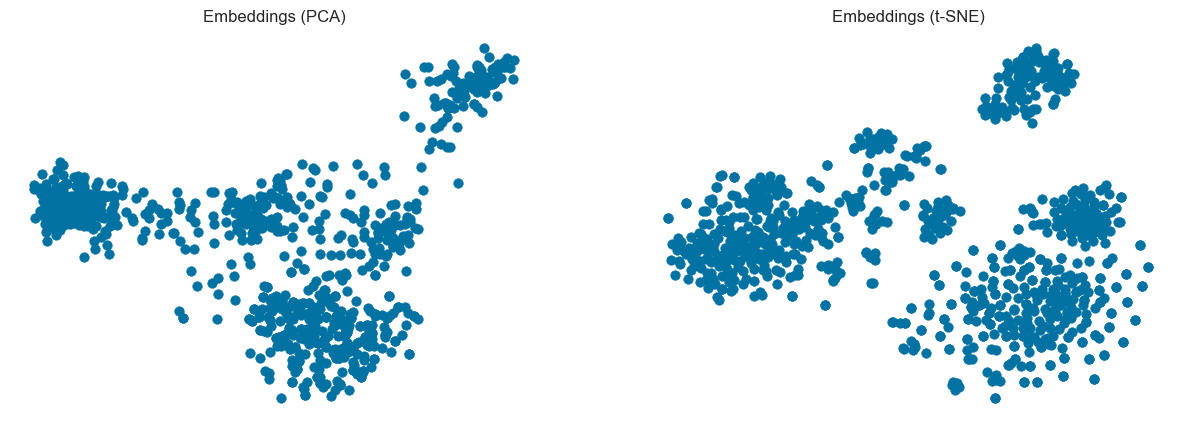

In [9]:
pca = sklearn.decomposition.PCA(n_components = 2)
tsne = sklearn.manifold.TSNE(n_components = 2)
pca_result = pca.fit_transform(np.stack(embeddings["embedding"].values))
tsne_result = tsne.fit_transform(np.stack(embeddings["embedding"].values))

def show_embeddings(pca_res, tsne_res, algo = None, clusters = None): 
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(pca_res[:, 0], pca_res[:, 1], c = clusters, cmap = "viridis" if clusters is not None else None)
    plt.axis("off")
    plt.title(f"Embeddings ({algo} + PCA)" if algo else "Embeddings (PCA)")
    plt.subplot(1, 2, 2)
    plt.scatter(tsne_res[:, 0], tsne_res[:, 1], c = clusters, cmap = "viridis" if clusters is not None else None)
    plt.axis("off")
    plt.title(f"Embeddings ({algo} + t-SNE)" if algo else "Embeddings (t-SNE)")
    plt.savefig(RUTA_IMG + f"reduced_embeddings_{algo}.pdf" if algo else RUTA_IMG + "reduced_embeddings.pdf", transparent = True)
    plt.show()

show_embeddings(pca_result, tsne_result)

Ahora se puede lanzar un algoritmo de clustering para intentar clasificar las imágenes en función de su información semántica. Se utilizarán varios distintos. En esta primera aproximación se va a suponer que se conce el número de clases, 5. 

In [10]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5, random_state = 1)
kmeans.fit(np.stack(embeddings["embedding"].values))
embeddings["cluster_kmeans"] = kmeans.labels_

ac = sklearn.cluster.AgglomerativeClustering(n_clusters = 5)
ac.fit(np.stack(embeddings["embedding"].values))
embeddings["cluster_ac"] = ac.labels_

embeddings.sample(5)

,imagen,embedding,clase_original,cluster_kmeans,cluster_ac
496,marcador_84.jpeg,"[-0.0182859823, 0.0436343774, 0.0182351116, 0....",2,3,4
47,camino_santiago_47.jpg,"[-0.00633023726, 0.0229962561, -0.0387691148, ...",0,2,2
155,cartel_143.jpeg,"[-0.00763046, 0.030499626, 0.00361630134, 0.02...",1,0,1
432,marcador_26.jpeg,"[-0.00319491047, 0.0496781543, 0.00520756794, ...",2,3,4
294,cartel_270.jpeg,"[-0.0293458905, 0.0437900797, -0.0334533155, 0...",1,0,1


Ahora se vuelven a mostrar los gráficos con los clusters obtenidos por los algoritmos. 

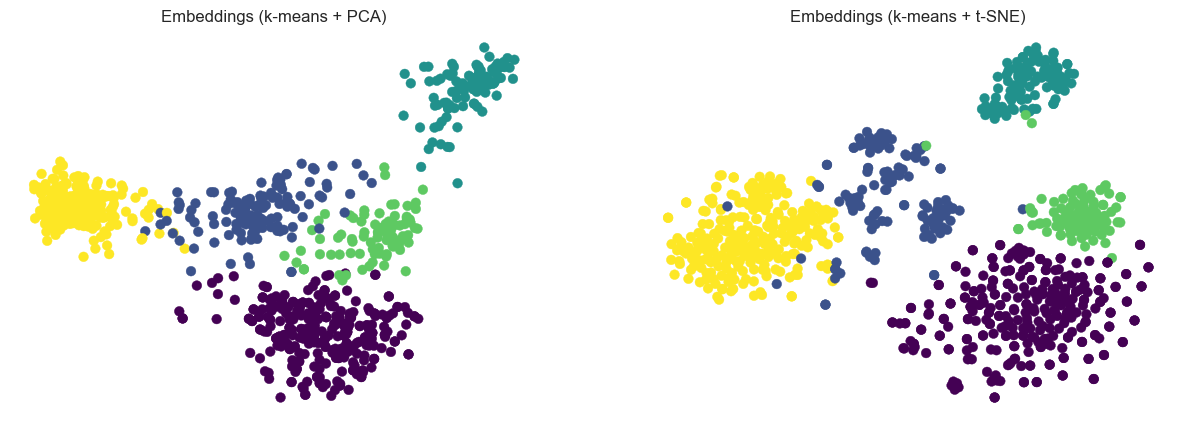

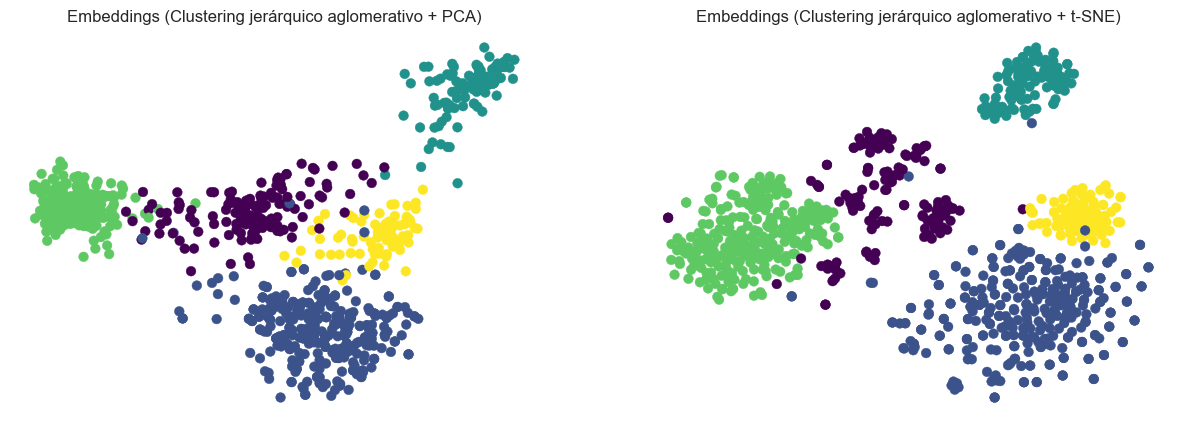

In [11]:
show_embeddings(pca_result, tsne_result, "k-means", embeddings["cluster_kmeans"])
show_embeddings(pca_result, tsne_result, "Clustering jerárquico aglomerativo", list(embeddings["cluster_ac"]))

Se pueden sustituir los puntos del t-SNE por las propias imágenes para ver mejor los diferentes clusters formados. Incluso dentro del cluster de `resto`, se pueden observar subclusters como murales, monumentos, etc. Ya que el algomerativo y k-means han obtenido resultados muy similares, se mostrará con k-means y t-SNE, por ejemplo. 

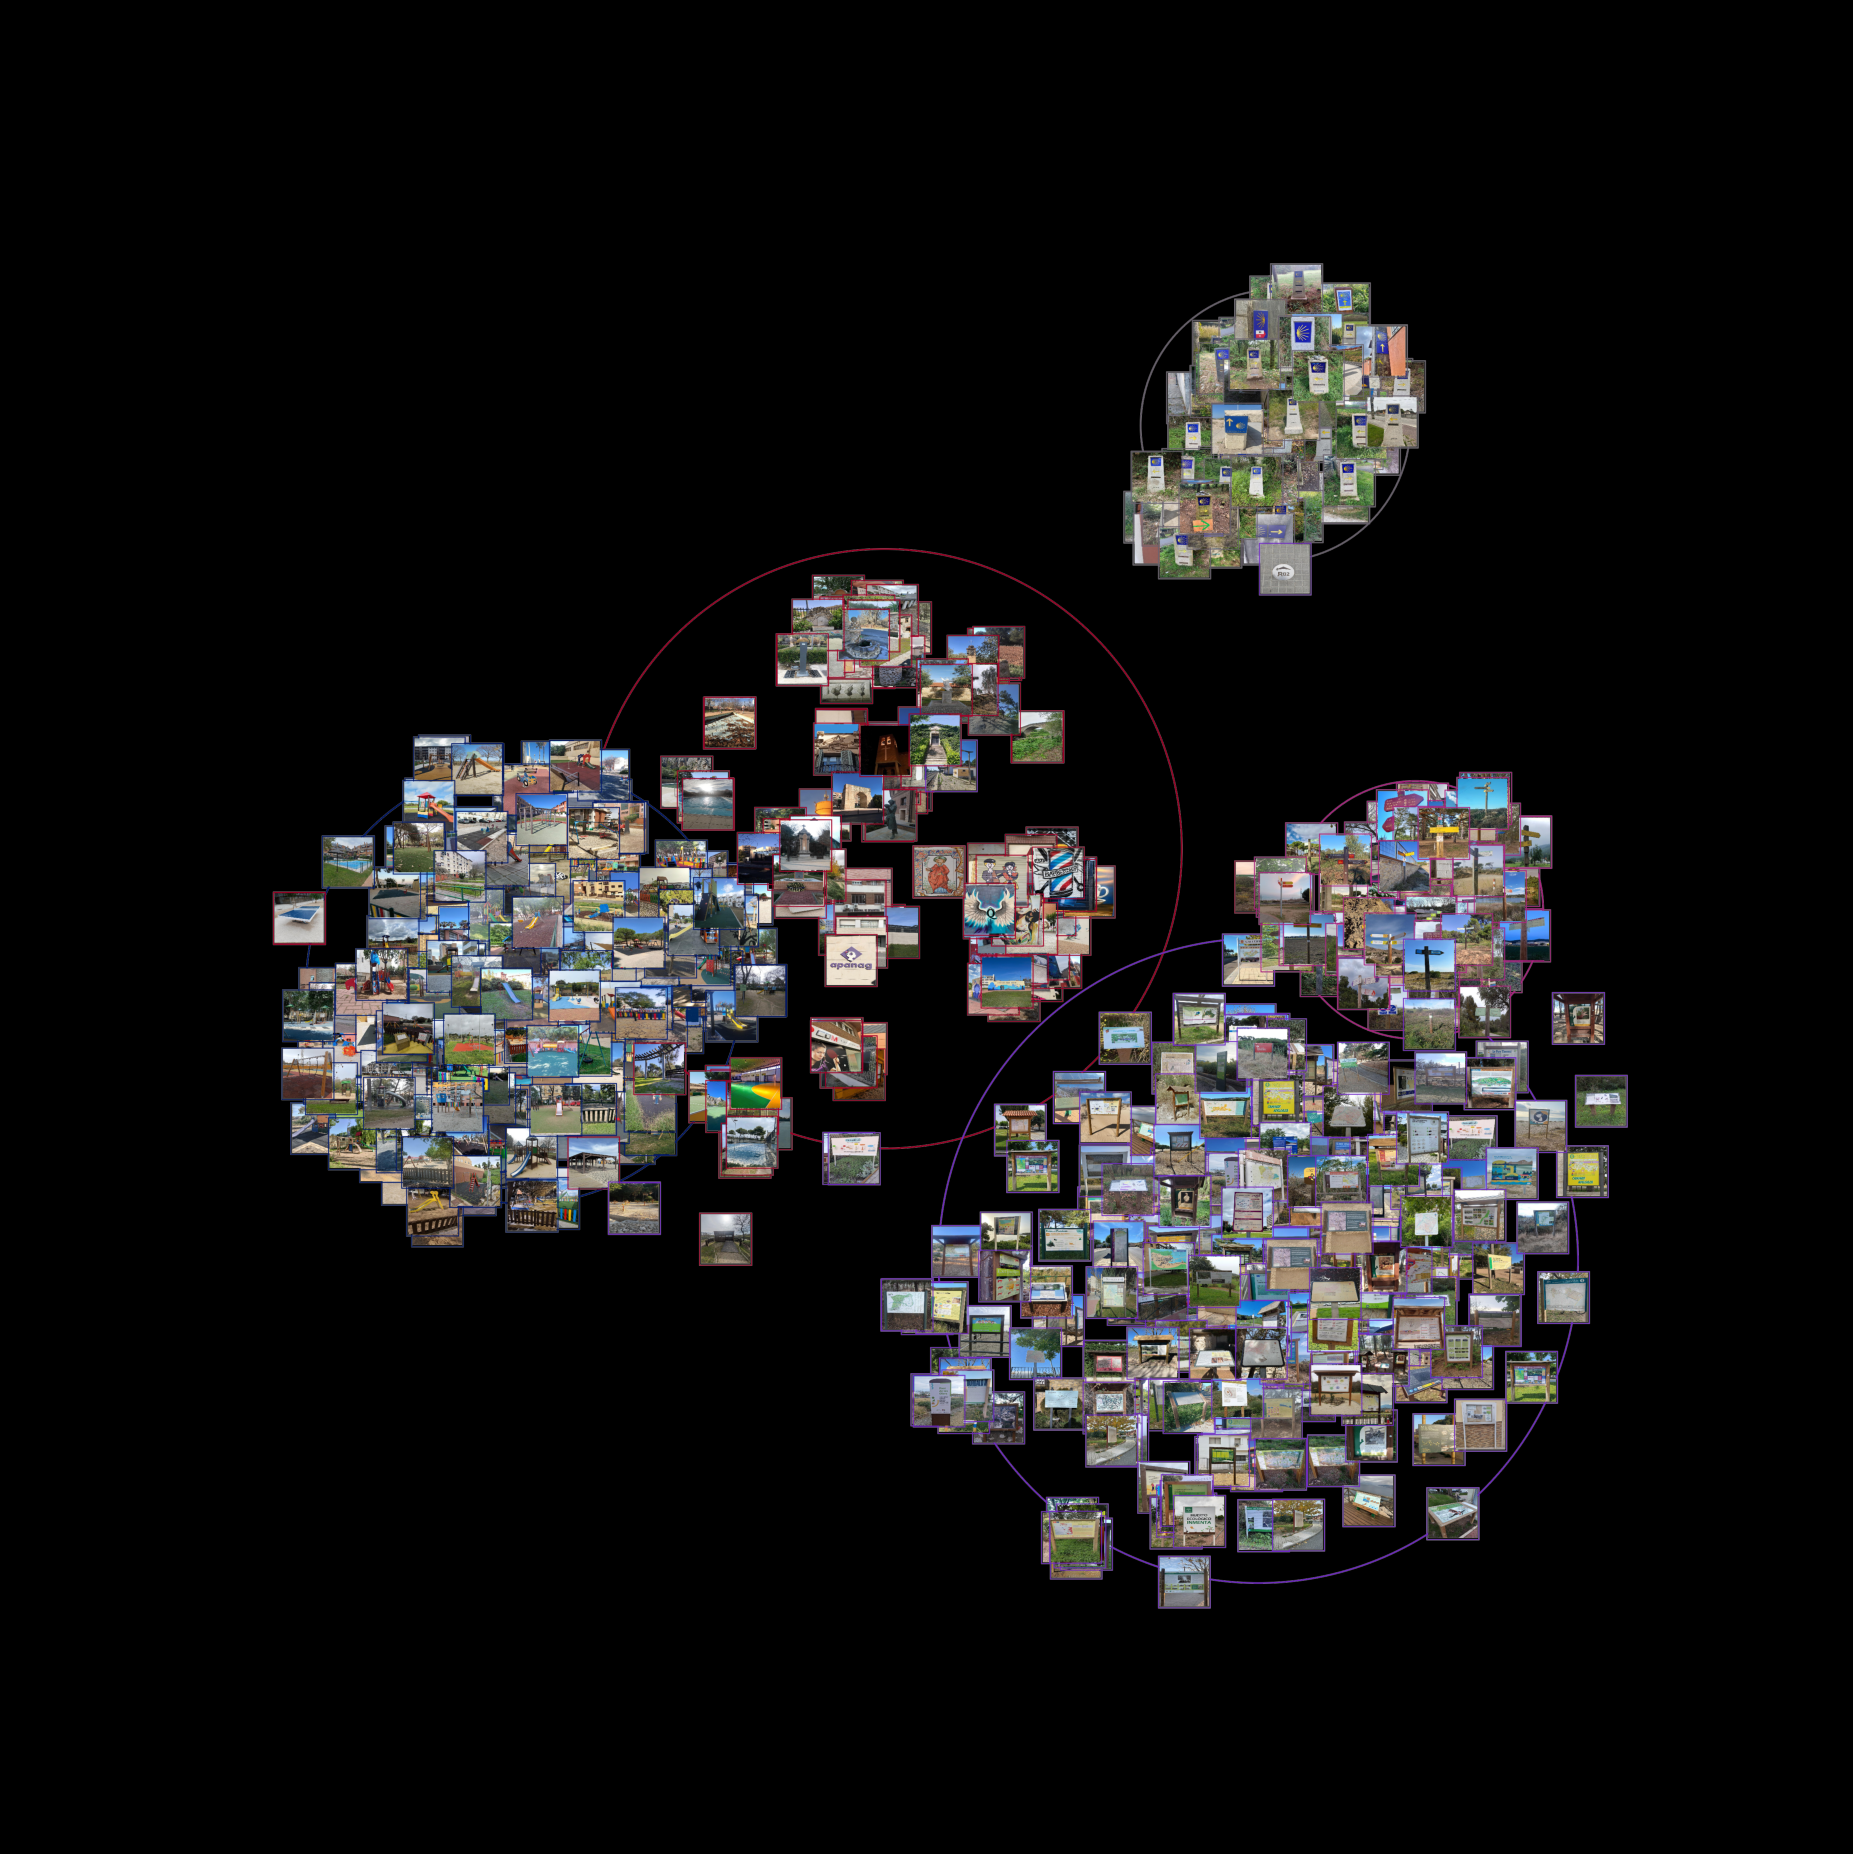

In [21]:
def show_img_clusters(imgs_info, reduced_embeddings, cluster_label): 
    if GENERAR_EMBEDDINGS: 
        plt.figure(figsize = (80, 80), dpi = 60).patch.set_facecolor("black")
        plt.axis("off")
        ax = plt.subplot()
        ax.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1])
        cluster_labels = np.unique(imgs_info[cluster_label])
        colores = ["#{:06x}".format(np.random.randint(0, 0xFFFFFF)) for _ in range(len(cluster_labels))]
        for i, (path_imagen, cluster) in enumerate(zip(imgs_info["imagen"], imgs_info[cluster_label])): 
            ab = matplotlib.offsetbox.AnnotationBbox(
                    matplotlib.offsetbox.OffsetImage(
                        PIL.Image.open(RUTA_DATASETS + DATASET_PREPROCESADO + path_imagen), 
                        zoom = 0.30), 
                    reduced_embeddings[i], xycoords = "data", frameon = True
                )
            ab.patch.set_edgecolor(colores[cluster])
            ab.patch.set_linewidth(3)
            ab.patch.set_facecolor("none")
            ax.add_artist(ab)
        for label in cluster_labels:
            points = reduced_embeddings[imgs_info[cluster_label] == label]
            centroid = points.mean(axis = 0)
            radius = np.sort(np.sqrt(np.sum((points - centroid) ** 2, axis = 1)))[int(points.shape[0] * -.1)]
            circle = matplotlib.patches.Circle(centroid, radius, fill = False, edgecolor = colores[label], linewidth = 5)
            ax.add_patch(circle)
        plt.savefig(RUTA_IMG + "images_clusters.png", transparent = True)
        plt.close()
    plt.figure(figsize = (80, 80), dpi = 30).patch.set_facecolor("black")
    plt.imshow(plt.imread(RUTA_IMG + "images_clusters.png"))
    plt.axis("off")
    plt.show()

show_img_clusters(embeddings, tsne_result, "cluster_ac")

Dentro del cluster que tiene los elementos desconocidos, se puede observar cómo existen pequeños subclusters, por ejemplo todos los murales aparecen juntos por un lado, los monumentos por otro, las fuentes y piscinas por otro, etc.

### Número de clases desconocidas
¿Y si en un principio no se conoce el número de clases? Se puede utilizar el método del codo (elbow method) con k-means tanto para determinar tanto el número de clusters, como para evaluar de manera no supervisada el proceso de clustering en caso de no conocer los clusters ideales. 

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

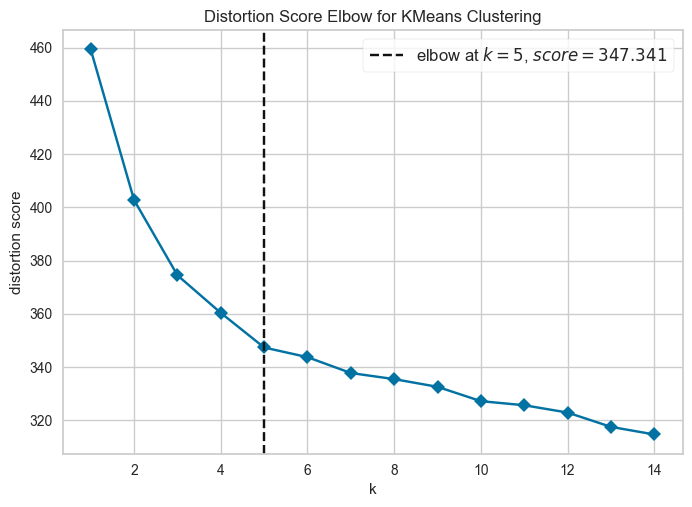

In [13]:
elbow_km = sklearn.cluster.KMeans(random_state = 1)
elbow = yellowbrick.cluster.KElbowVisualizer(elbow_km, k = (1, 15), timings = False)
elbow.fit(np.stack(embeddings["embedding"].values))
elbow.show(outpath = RUTA_IMG + "elbow_kmeans.pdf")

De esta manera, se obtiene el número de centroides para k-means idéntico al que se había usado en base al conocimiento del dataset. K-means trata de minimizar el valor de la distancia de cada elemento a su centroide (WCSS), o lo que es lo mismo, 
$$
\argmin_{|S|}\sum_{i = 1}^k\sum_{\textbf{x}\in S_i}\|\textbf{x}-\mu_i\|^2. 
$$
Por ello, el método del codo elige el $k$ que genera un cambio más brusco en esta función. Otra manera de elegir el número adecuado de clusters, es mediante el coeficiente de la silueta. De manera similar, el que mejor puntuación de silueta obtenga será el elegido. Varía entre $-1$ y $1$. Dicha puntuación obedece a la siguiente ecuación. 
$$
\begin{gathered}
    a_i = \frac{1}{|C_i| - 1}\sum_{\substack{\textbf{x}_j\in C_i\\ i\neq j}}\|\textbf{x}_i - \textbf{x}_j\|\\
    b_i = \min_{i\neq j}\frac{1}{|C_j|}\sum_{\textbf{x}_j\in C_j}\|\textbf{x}_i - \textbf{x}_j\|\\
    \mathcal{S} = \frac{1}{n}\sum_{i = 1}^{n}\frac{b_i - a_i}{\text{máx}\{a_i, b_i\}}
\end{gathered}
$$

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 887 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

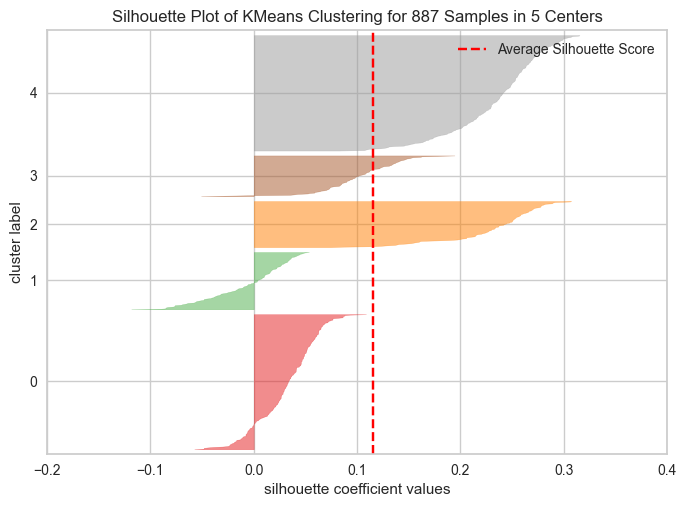

In [14]:
sil = yellowbrick.cluster.SilhouetteVisualizer(kmeans)
sil.fit(np.stack(embeddings["embedding"].values))
sil.show(outpath = RUTA_IMG + "silhouette_kmeans.pdf")

En este caso se obtiene una puntuación mala para el valor de $k$ elegido mediante WCSS, lo que indica que posiblemente al utilizar el de la silueta no se eligiese el mismo valor de $k$. Sin embargo, mediante el conocimiento del dataset se sabe que el método del codo ha acertado con el valor. 

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

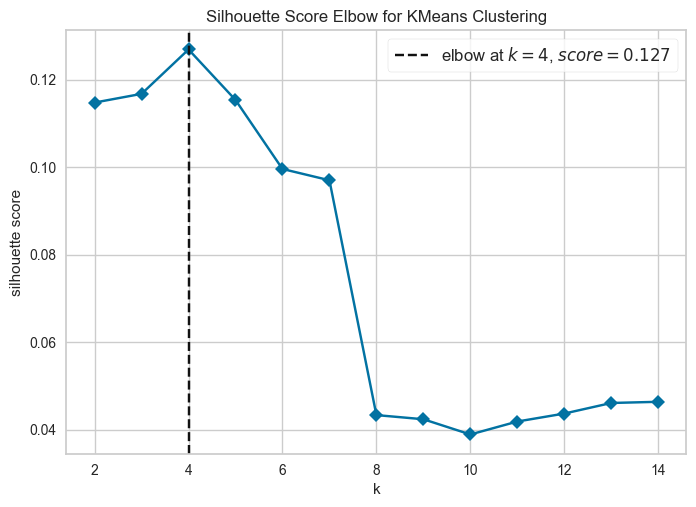

In [15]:
elbow_sil = yellowbrick.cluster.KElbowVisualizer(elbow_km, k = (2, 15), metric = "silhouette", timings = False)
elbow_sil.fit(np.stack(embeddings["embedding"].values))
elbow_sil.show(outpath = RUTA_IMG + "elbow_sil_kmeans.pdf")

¿A qué se debe esta discordancia? Al utilizar el WCSS se puntúa la calidad del clustering de acuerdo a la similitud entre los elementos de cada cluster, mientras que con la silueta, además mide la separación entre clusters. Los valores obtenidos indican que los elementos son similares dentro de cada cluster, pero los clusters están muy cercanos o solapándose. 

### Evaluación del procedimiento

A continuación se va a evaluar de manera supervisada cómo de buena ha sido la clusterización. Para ello se va a utilizar el índice rand ajustado, que evalúa entre -1 y 1 la similitud entre dos procesos de clustering $\mathcal{C} = \{C_1, C_2, \ldots, C_r\}$ y $\mathcal{D} = \{D_1, D_2, \ldots, D_s\}$. Inicialmente se calcula el índice rand, para lo que se construye la llamada matriz de contingencia, donde el elemento $n_{ij}$ almacena el valor de $|C_i \cap D_j|$. 

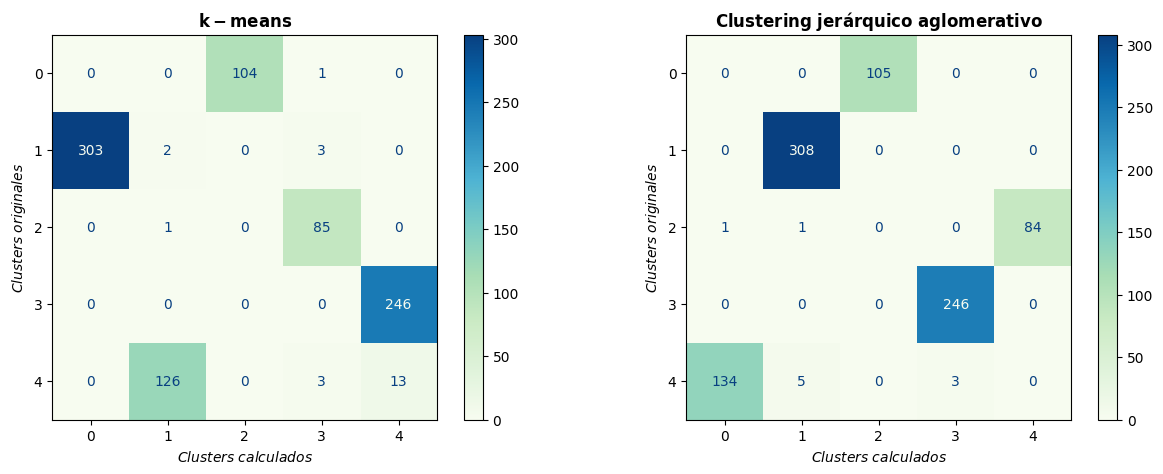

In [16]:
def mostrar_matrices(v1, v2, save = False): 
    plt.rcParams.update(plt.rcParamsDefault)
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
    plt.title(r"$\mathbf{k-means}$")
    sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = v1).plot(
        include_values = True, 
        cmap = plt.cm.GnBu,
        ax = plt.gca()
    )
    plt.gca().set_xlabel(r"$\mathit{Clusters\,\,calculados}$")
    plt.gca().set_ylabel(r"$\mathit{Clusters\,\,originales}$")
    plt.subplot(1, 2, 2)
    plt.title(r"$\mathbf{Clustering\,\,jerárquico\,\,aglomerativo}$")
    sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = v2).plot(
        include_values = True, 
        cmap = plt.cm.GnBu, 
        ax = plt.gca()
    )
    plt.gca().set_xlabel(r"$\mathit{Clusters\,\,calculados}$")
    plt.gca().set_ylabel(r"$\mathit{Clusters\,\,originales}$")
    if save:
        plt.savefig(RUTA_IMG + save + ".pdf", transparent = True)
    plt.show()

mostrar_matrices(sklearn.metrics.cluster.contingency_matrix(embeddings["clase_original"], embeddings["cluster_kmeans"]), 
    sklearn.metrics.cluster.contingency_matrix(embeddings["clase_original"], embeddings["cluster_ac"]), "matrices_contingencia")

El índice rand calcula la similaritud entre ambos clusterings mediante la comparación de cada posible pareja de elementos. Para cada pareja puede darse uno de los siguientes casos entre los que se distinguen acuerdos y desacuerdos.  

* $u \in C_p, \, v \in C_p, \, u \in D_q, \, v \in D_q$
* $u \in C_p, \, v \in C_p, \, u \in D_q, \, v \not\in D_q$
* $u \in C_p, \, v \not\in C_p, \, u \in D_q, \, v \in D_q$
* $u \in C_p, \, v \not\in C_p, \, u \in D_q, \, v \not\in D_q$

Mediante cada uno de estos cuatro casos se puede construir una matriz de confusión $2 \times 2$ que relacione el clustering original con el calculado. 

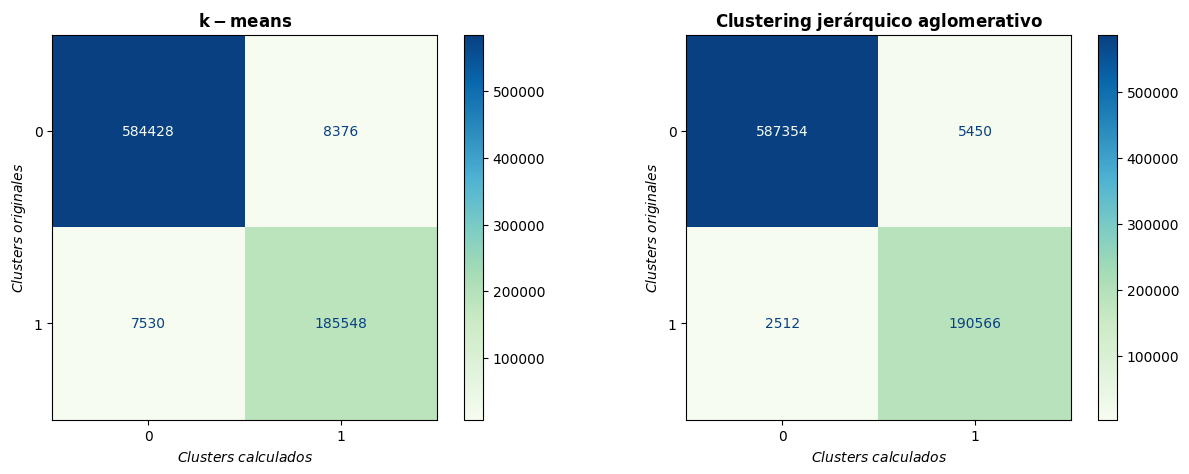

In [17]:
cm_kmeans = sklearn.metrics.cluster.pair_confusion_matrix(embeddings["clase_original"], embeddings["cluster_kmeans"])
cm_ac = sklearn.metrics.cluster.pair_confusion_matrix(embeddings["clase_original"], embeddings["cluster_ac"])
mostrar_matrices(cm_kmeans, cm_ac, "matrices_confusion_transf")

In [18]:
(cm_kmeans[0,0] + cm_kmeans[1,1]) / cm_kmeans.sum() == sklearn.metrics.rand_score(embeddings['clase_original'], embeddings['cluster_kmeans']) and (cm_ac[0,0] + cm_ac[1,1]) / cm_ac.sum() == sklearn.metrics.rand_score(embeddings['clase_original'], embeddings['cluster_ac'])

True

En estas matrices se ve de manera más clara cómo calcular el rand index $\mathcal{R}_I$ que en la matriz de contingencia. Dicho valor se calcula como el número de acuerdos $A$ frente al número total de posibles parejas,  
$$
\frac{A}{A + D} = \frac{\displaystyle\binom{n}{2} + 2\sum_{i = 1}^r\sum_{j = 1}^s \binom{n_{ij}}{2} - \left(\sum_{i = 1}^r \binom{\sigma_i}{2} + \sum_{j = 1}^s \binom{\sigma_j}{2}\right)}{\displaystyle\binom{n}{2}}, 
$$
donde $\displaystyle\sigma_i = \sum_{j = 1}^s n_{ij}$ y $\displaystyle\sigma_j = \sum_{i = 1}^r n_{ij}$. Para evitar la similitud por azar, se calcula el ARI como
$$
\frac{\mathcal{R}_I - E[\mathcal{R}_I]}{1 - E[\mathcal{R}_I]}, 
$$
indicando los valores próximos a $-1$ una mal clustering, los cercanos a $1$ un buen clustering, siendo menor a cero los casos peores que hacerlo al azar. 

In [19]:
print(f"k-means: {round(sklearn.metrics.adjusted_rand_score(embeddings['clase_original'], embeddings['cluster_kmeans']), 3)}")
print(f"Clustering aglomerativo: {round(sklearn.metrics.adjusted_rand_score(embeddings['clase_original'], embeddings['cluster_ac']), 3)}")

k-means: 0.945
Clustering aglomerativo: 0.973


Por otro lado, al igual que en los problemas de clasificación tradicionales se podía calcular el $F_1$-score, al tratar de comparar el resultado de un algoritmo de clustering con las clases originales, es común utilizar el $V_1$-score, que es la media armónica de la homogeneidad y completitud. 

In [20]:
print(f"k-means: {tuple(map(lambda x: round(x, 3), sklearn.metrics.homogeneity_completeness_v_measure(embeddings['clase_original'], embeddings['cluster_kmeans'])))}")
print(f"Clustering aglomerativo: {tuple(map(lambda x: round(x, 3), sklearn.metrics.homogeneity_completeness_v_measure(embeddings['clase_original'], embeddings['cluster_ac'])))}")

k-means: (0.925, 0.926, 0.926)
Clustering aglomerativo: (0.959, 0.964, 0.962)
